In [1]:
%load_ext autoreload
%autoreload 2

In [42]:
%matplotlib inline
import numpy 
import random
import time 
import sys
import os
import tifffile
import io
import pickle
import matplotlib
import yaml

from matplotlib import pyplot
from PIL import Image
from tqdm.auto import trange
from skimage import filters
from collections import defaultdict

from pysted import base, utils, raster, bleach_funcs
from banditopt.objectives import Resolution, Bleach
from banditopt.utils import get_foreground

from stedopt.tools import DatamapGenerator
from stedopt.create import create_microscope, create_dymin_microscope, create_rescue_microscope
from stedopt.experiment import Experiment
from stedopt.defaults import P_EX, P_STED, PDT

fluo = { # ATTO647N
    "lambda_": 690e-9, # Figure 1, Oracz2017
    "qy": 0.65,  # Product Information: ATTO 647N (ATTO-TEC GmbH)
    "sigma_abs": {
        635: 2.14e-20, #Table S3, Oracz2017
        750: 3.5e-25,  # (1 photon exc abs) Table S3, Oracz2017
    },
    "sigma_ste": {
#         750: 4.8e-22, #Table S3, Oracz2017
        750: 3.0e-22, #Table S3, Oracz2017        
    },
    "tau": 3.5e-9, #Table S3, Oracz2017
    "tau_vib": 1.0e-12, #t_vib, Table S3, Oracz2017 
    "tau_tri": 1.2e-6, # pasted from egfp
    "k0": 0, #Table S3, Oracz2017
#     "k1": 1.3e-15, #Table S3,  (changed seemingly wrong unit: 5.2 × 10−10 / (100**2)**1.4)
#     "b":1.4, #Table S3, Oracz2017    
#     "k1": 1.3e-15, #tests_photobleaching.py 2022-08-28
    "k1": 1.3e-15, #tests_photobleaching.py 2022-08-28    
    "b": 1.62, #Table S3, Oracz2017    
    "triplet_dynamics_frac": 0, #Ignore the triplet dynamics by default
}
fluo = {
    "lambda_": 6.9e-7,
    "qy": 0.65,
    "sigma_abs": {
        635: 1e-20,
        750: 3.5e-25
    },
    "sigma_ste": {
        750: 4.8e-22
    },
    "tau": 3.5e-9,
    "tau_vib": 1e-12,
    "tau_tri": 0.000025,
    "k0": 0,
    "k1": 1.3e-15,
    "b": 1.45,
    "triplet_dynamics_frac": 0
}

objective = {"transmission" : {488: 0.84, 535: 0.85, 550: 0.86, 585: 0.85, 575: 0.85, 635: 0.85, 690: 0.85, 750: 0.85}}
laser_ex = {"lambda_" : 635e-9}
laser_sted = {"lambda_" : 750e-9, "zero_residual" : 0.01, "anti_stokes" : True}
num_mol = 40


In [43]:
def savefig(fig, ax, savepath, extension="pdf", save_white=False, **kwargs):
    """
    Utilitary function allowing to save the figure to 
    the savepath
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`  
    :param savepath: A `str` of the filename
    :param extension: A `str` of the extension of the file
    :param save_white: A `bool` wheter to save the figure in white version 
                       as well
    """
    fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True)
    if save_white:
        dirname = os.path.dirname(savepath)
        basename = os.path.basename(savepath)
        
        # Creates empty directory
        os.makedirs(os.path.join(dirname, "white"), exist_ok=True)
        savepath = os.path.join(dirname, "white", basename)

        buf = io.BytesIO()
        pickle.dump(fig, buf)
        buf.seek(0)
        fig = pickle.load(buf)
        
        change_figax_color(fig, ax, **kwargs)
        fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True, dpi=600)
        
        pyplot.close(fig)
        
def change_figax_color(fig, ax):
    """
    Utilitary function allowing to change the figure and 
    ax color from black to white
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`    
    """
    def _change_ax(ax):
        ax.set_facecolor("none")
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('white')      
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        ax.title.set_color("white")
        
        # For line plots
        for line in ax.get_lines():
            if line.get_color() in ["#000000", "000000", "black"]:
                line.set_color("white")    

        # For scatter plots
        for collection in ax.collections:
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_facecolors()]
            new_colors = [mimic_white_alpha(c) for c in new_colors]
            collection.set_facecolors(new_colors)
            collection.set_alpha(1)
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_edgecolors()] 
            new_colors = [mimic_white_alpha(c) for c in new_colors]            
            collection.set_edgecolors(new_colors)
            collection.set_alpha(1)            

        # For hist plots
        for patch in ax.patches:
            c = patch.get_facecolor()
            if matplotlib.colors.to_hex(c) == "#000000":
                patch.set_color("white")        
        
    # Change figure background
    fig.patch.set_facecolor("none")
    
    # Changes colorbars if any
    for ax in fig.axes:
        _change_ax(ax.axes)
        
def mimic_white_alpha(color):
    """
    Mimics the color that would be perceived of a color on a white 
    background
    
    :param color: A `matplotlib.collections` of lines
    
    :returns : A `list` of the colors
    """
    c_rgba = matplotlib.colors.to_rgba(color)
    c_rgb, alpha = c_rgba[:3], c_rgba[-1]
    return matplotlib.colors.to_hex(tuple(c * alpha + (1 - alpha) for c in c_rgb))    

In [44]:
def kb_map_to_im_bleach(kb_map, dwelltime, linestep):
    """ 
    Bleaching estimate for an infinite number of fluorophores
    kb_map being the map of k_bleach convolving each pixel
    """
    return 1 - (numpy.exp((-kb_map * dwelltime * linestep).sum()))

def expected_bleach(microscope, p_ex, p_sted, pdt, pixelsize=20e-9):
    __i_ex, __i_sted, psf_det = microscope.cache(pixelsize)
    
    i_ex = __i_ex * p_ex #the time averaged excitation intensity
    i_sted = __i_sted * p_sted #the instant sted intensity (instant p_sted = p_sted/(self.sted.tau * self.sted.rate))
    
    lambda_ex, lambda_sted = microscope.excitation.lambda_, microscope.sted.lambda_
    tau_sted = microscope.sted.tau
    tau_rep = 1 / microscope.sted.rate
    phi_ex =  microscope.fluo.get_photons(i_ex, lambda_=lambda_ex)
    phi_sted = microscope.fluo.get_photons(i_sted, lambda_=lambda_sted)
    
    kb_map = microscope.fluo.get_k_bleach(lambda_ex, lambda_sted, phi_ex, phi_sted*tau_sted/tau_rep, tau_sted, tau_rep, pdt)
    bleach = kb_map_to_im_bleach(kb_map, pdt, 1)
    return min(bleach, 1)

In [45]:
%matplotlib notebook
P_STED = 60e-3
P_EX = 1.2e-6
PDT = 3.0e-6

numpy.random.seed(42)
random.seed(42)

NUM_ACQ = 5
NUM_REPS = 1
all_histories = []
i = 1
datamap_generator = DatamapGenerator(
    mode="generatewithoutoverlap", shape=(128, 128), path=["../../data/datamap/psd95"], random_state=42 + i,
    molecules=100, sources=50
)
molecules_disposition, positions = datamap_generator(idx=i)

microscope, datamap, params = create_microscope(
    datamap = {
        "whole_datamap" : molecules_disposition,
        "datamap_pixelsize" : 20e-9
    },
    fluo=fluo, laser_ex=laser_ex, laser_sted=laser_sted, objective=objective,
    imaging = {"p_ex" : P_EX, "p_sted" : P_STED, "pdt" : PDT}
)
print(microscope.fluo.b)
bleach = expected_bleach(microscope, P_EX, P_STED, PDT)
print("Expected Bleach", bleach)

# for i in trange(min(1, len(datamap_generator.datamaps)), leave=False):
for i in range(10):
# for i in trange(len(datamap_generator.datamaps), leave=False):    
#     molecules_disposition, positions = datamap_generator(idx=i + 20)
    
    molecules_disposition, positions = datamap_generator(
#         sources = 50,
#         molecules = 100,
#         shape_sources = (2, 2),
        random_state = 42 + i
    )    
    
    experiment = Experiment()
    
    microscope, datamap, params = create_microscope(
        datamap = {
            "whole_datamap" : molecules_disposition,
            "datamap_pixelsize" : 20e-9
        },
        fluo=fluo, laser_ex=laser_ex, laser_sted=laser_sted, objective=objective,
        imaging = {"p_ex" : P_EX, "p_sted" : 0., "pdt" : PDT}
    )
    experiment.add("CONF1", microscope, datamap, params)    
    experiment.add("CONF2", microscope, datamap, params)    
    
    microscope, _, params = create_microscope(
        datamap = {
            "whole_datamap" : molecules_disposition,
            "datamap_pixelsize" : 20e-9
        },
        fluo=fluo, laser_ex=laser_ex, laser_sted=laser_sted, objective=objective,
        imaging = {"p_ex" : P_EX, "p_sted" : P_STED, "pdt" : PDT}
    )
    experiment.add("STED", microscope, datamap, params)

    histories = {}
    for name in ["CONF1", "STED", "CONF2"]:
        start = time.time()
        name, history = experiment.acquire(name, 1 if "CONF" in name else NUM_ACQ, bleach="CONF" not in name, verbose=False)
        print(time.time() - start)
        histories[name] = history
    
    all_histories.append(histories)
    

1.45
Expected Bleach 0.0001978812240299721
0.2663252353668213
5.461510419845581
0.2653486728668213
0.2662675380706787
5.887247323989868
0.26240110397338867
0.2630903720855713
6.036318063735962
0.2649364471435547
0.2638974189758301
6.034235715866089
0.2639791965484619
0.2645266056060791
6.014794588088989
0.2629532814025879
0.26320934295654297
5.8293445110321045
0.26459741592407227
0.2815861701965332
5.6346094608306885
0.26325201988220215
0.2637820243835449
5.661585569381714
0.2700834274291992
0.26714420318603516
5.729496955871582
0.2617044448852539
0.26873040199279785
5.627883195877075
0.27161645889282227


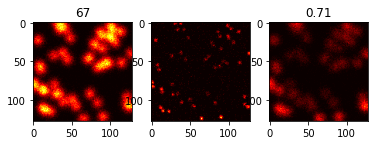

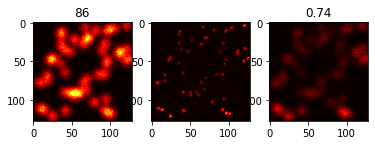

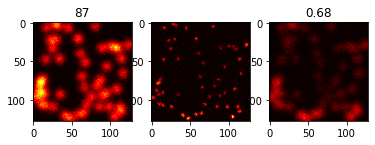

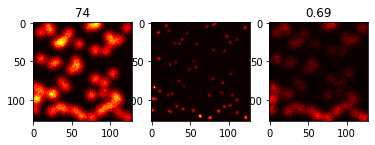

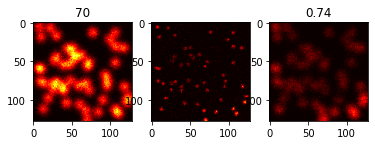

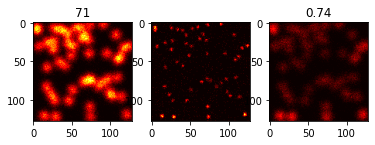

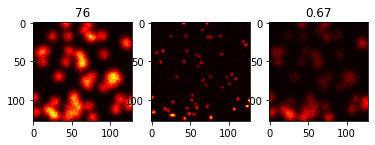

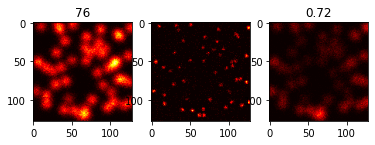

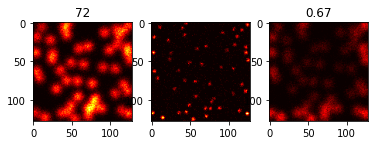

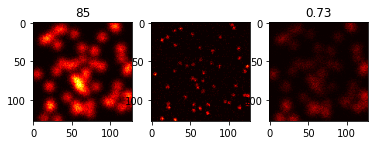

max 76.4 6.8
bleach 0.7104534681256713 0.028674798010089837
resolution 67.39435796625673 7.240419802788568


In [46]:
%matplotlib inline

resolution_objective = Resolution(20e-9)
bleach_objective = Bleach()

maxes = []
stats = defaultdict(list)
for histories in all_histories:
    conf1 = histories["CONF1"]["acquisition"][-1]
    conf2 = histories["CONF2"]["acquisition"][-1]        
    sted_image = histories["STED"]["acquisition"][-1]

    fg_c = get_foreground(conf1)
    fg_s = get_foreground(sted_image)
    fg_s *= fg_c

    resolutions = resolution_objective.evaluate([sted_image], conf1, conf2, fg_s, fg_c)
    bleach = bleach_objective.evaluate([sted_image], conf1, conf2, fg_s, fg_c)
    
    fig, axes = pyplot.subplots(1, 3)
    axes[0].imshow(conf1, cmap="hot")
    axes[0].set_title(conf1.max())
    axes[1].imshow(sted_image, cmap="hot")     
    axes[2].imshow(conf2, cmap="hot", vmax=conf1.max())    
    axes[2].set_title(f"{bleach:0.2f}")
    pyplot.show()
    
    maxes.append(conf1.max())
    stats["max"].append(conf1.max())
    stats["bleach"].append(bleach)
    stats["resolution"].append(resolutions)
    
for key, values in stats.items():
    print(key, numpy.mean(values), numpy.std(values))

# Optimize

In [5]:
from skimage import filters

def kb_map_to_im_bleach(kb_map, dwelltime, linestep):
    """ 
    Bleaching estimate for an infinite number of fluorophores
    kb_map being the map of k_bleach convolving each pixel
    """
    return 1 - numpy.exp((-kb_map * dwelltime * linestep).sum())

def expected_bleach(microscope, p_ex, p_sted, pdt, pixelsize=20e-9):
    __i_ex, __i_sted, psf_det = microscope.cache(pixelsize)
    
    i_ex = __i_ex * p_ex #the time averaged excitation intensity
    i_sted = __i_sted * p_sted #the instant sted intensity (instant p_sted = p_sted/(self.sted.tau * self.sted.rate))
    
    lambda_ex, lambda_sted = microscope.excitation.lambda_, microscope.sted.lambda_
    tau_sted = microscope.sted.tau
    tau_rep = 1 / microscope.sted.rate
    phi_ex =  microscope.fluo.get_photons(i_ex, lambda_=lambda_ex)
    phi_sted = microscope.fluo.get_photons(i_sted, lambda_=lambda_sted)
    
    kb_map = microscope.fluo.get_k_bleach(lambda_ex, lambda_sted, phi_ex, phi_sted*tau_sted/tau_rep, tau_sted, tau_rep, pdt)
    bleach = kb_map_to_im_bleach(kb_map, pdt, 1)
    return bleach

def expected_confocal_signal(microscope, p_ex, p_sted, pdt, pixelsize=20e-9, sigma=2.25, scale_factor=40): # CaMKII & PSD95
# def expected_confocal_signal(microscope, p_ex, p_sted, pdt, pixelsize=20e-9, sigma=3.0, scale_factor=40): # Actin
# def expected_confocal_signal(microscope, p_ex, p_sted, pdt, pixelsize=20e-9, sigma=3.75, scale_factor=40): # Tubulin & Lifeact
    
    # sigma_abs
    photons_mean = []
    for _ in range(25):
        effective = microscope.get_effective(pixelsize, p_ex, p_sted)
        datamap = numpy.zeros_like(effective)
        cy, cx = (s // 2 for s in datamap.shape)
        datamap[cy, cx] = 1
        datamap = filters.gaussian(datamap, sigma=sigma)
        datamap = datamap / datamap.max() * scale_factor

        intensity = numpy.sum(effective * datamap)
        photons = microscope.fluo.get_photons(intensity)
        photons = microscope.detector.get_signal(photons, pdt, microscope.sted.rate)
        photons_mean.append(photons)
    photons = numpy.mean(photons_mean)
    return photons

def optimize_bleach(x, microscope, p_ex, p_sted, pdt, target):
    
    k1, b = x
    microscope.fluo.k1 = k1 * 1e-15
    microscope.fluo.b = b
    bleach = expected_bleach(microscope, p_ex, p_sted, pdt)
    error = (target - bleach) ** 2
    return error

def optimize_sigma_abs(sigma_abs, microscope, p_ex, p_sted, pdt, target):
    
    microscope.fluo.sigma_abs = {
        int(microscope.excitation.lambda_ * 1e9) : sigma_abs * 1e-20, 
        int(microscope.sted.lambda_ * 1e9): 3.5e-25,
    }

    signal = expected_confocal_signal(microscope, p_ex, 0., pdt)
    error = ((target - signal) / target) ** 2
    
    return error

In [265]:
from scipy import optimize

from stedopt import defaults
from skimage import filters

defaults.FLUO = { # ATTO647N
    "lambda_": 6.9e-7,
    "qy": 0.65,
    "sigma_abs": {
        635: 2.14e-20,
        750: 3.5e-25
    },
    "sigma_ste": {
        750: 3.0e-22
    },
    "tau": 3.5e-9,
    "tau_vib": 1e-12,
    "tau_tri": 0.0000012,
    "k0": 0,
    "k1": 1.3e-15,
    "b": 1.6,
    "triplet_dynamics_frac": 0
}

class FluorescenceOptimizer():
    """
    Optimizes the parameters of fluorescence to obtain the 
    given photobleaching and signal in the acquired images.
    """
    FACTORS = {
        "clusters" : 2.25, # CaMKII & PSD95
        "actin" : 3.0,
        "tubulin" : 3.75
    }
    
    def __init__(self, microscope, sample="clusters", iterations=10, pixelsize=20e-9):
        """
        Instantiates the `FluorescenceOptimizer`
        
        :param microscope: A `pysted.base.Microscope` object
        :param sample: A `str` of the sample type that is being optimized
        :param iterations: An `int` of the number of iterations to perform
        """
        self.microscope = microscope
        self.iterations = iterations
        self.pixelsize = pixelsize
        
        assert sample in ["clusters", "actin", "tubulin"]
        self.correction_factor = self.FACTORS[sample]
        self.scale_factor = 40.
        
        # This seems to be optimal for a starting point
        self.microscope.fluo.sigma_abs = defaults.FLUO["sigma_abs"]
        self.microscope.fluo.k1 = defaults.FLUO["k1"]
        self.microscope.fluo.b = defaults.FLUO["b"]
        
    def default_parameters(self):
        """
        Returns the default parameters
        """
        return defaults.FLUO["k1"], defaults.FLUO["b"], defaults.FLUO["sigma_abs"]
    
    def aggregate(self, criterions, **kwargs):
        """
        Aggregates the returned values 
        """
        out = {}
        if "bleach" in criterions:
            out["bleach"] = {
                "k1" : kwargs.get("k1") * 1e-15,
                "b" : kwargs.get("b")
            }
        if "signal" in criterions:
            sigma_abs = self.microscope.fluo.sigma_abs
            out["signal"] = {
                "sigma_abs" : {
                    int(microscope.excitation.lambda_ * 1e9) : kwargs.get("sigma_abs") * 1e-20, 
                    int(microscope.sted.lambda_ * 1e9) : sigma_abs[int(microscope.sted.lambda_ * 1e9)]
                }
            }
        return out
    
    def optimize(self, criterions):
        """
        Optimizes the fluorescene parameters given the input criterions
        that have to be met. The optimization of the parameters is done 
        sequentially has this seems to produce decent results on the datamaps
        that were tested. However, a multi-objective approach (e.g. NSGA-II) 
        could be better suited to find the Pareto choices.
        
        :param criterions: A `dict` of criterions
        
        :returns : A `dict` of the optimized parameters
        
        :example : 
        
        criterions = {
            "bleach" : {
                "p_ex" : <VALUE>,
                "p_sted" : <VALUE>,
                "pdt" : <VALUE>,
                "target" : <VALUE>
            },
            "signal" : {
                "p_ex" : <VALUE>,
                "p_sted" : <VALUE>,
                "pdt" : <VALUE>,
                "target" : <VALUE>
            },
        }
        params = optimizer.optimize(criterions)
        >>> params
        {
            "bleach" : {
                "k1" : <VALUE>,
                "b" : <VALUE>
            },
            "signal" : {
                "sigma_abs" : {
                    635 : <VALUE>,
                    750 : <VALUE>
                }
            }
        }
        """
        k1, b, sigma_abs = self.default_parameters()
        sigma_abs = sigma_abs[int(microscope.excitation.lambda_ * 1e9)]
        
        # scales values
        k1 = k1 * 1e+15
        sigma_abs = sigma_abs * 1e+20
        
        k1, b, sigma_abs = 0.29, 1.66, 0.32
        print(k1, b, sigma_abs)
        
        for i in range(self.iterations):
            

            # Optimize signal constant
            params = criterions.get("signal", None)
            if params:            
                current = self.expected_confocal_signal(params["p_ex"], params["p_sted"], params["pdt"])
                weighted_target = current + (i + 1) / self.iterations * (params["target"] - current)
#                 weighted_target = params["target"]                
#                 print("signal", weighted_target)
                res = optimize.minimize(
                    self.optimize_sigma_abs, x0=[sigma_abs], 
                    args=(params["p_ex"], params["p_sted"], params["pdt"], weighted_target), 
                    options={"eps" : 0.01, "maxiter": 25}, tol=1e-3, 
                    bounds = [(0., numpy.inf)]
                )
                sigma_abs = res.x.item()                 
        
            params = criterions.get("bleach", None)
            if params:
                # Optimize bleaching constants
                current = self.expected_bleach(params["p_ex"], params["p_sted"], params["pdt"])
                weighted_target = current + (i + 1) / self.iterations * (params["target"] - current)
#                 weighted_target = params["target"]           
#                 print("bleach", weighted_target)
                res = optimize.minimize(
                    self.optimize_bleach, x0=[k1, b], 
                    args=(params["p_ex"], params["p_sted"], params["pdt"], weighted_target), 
                    options={"eps" : 0.01, "maxiter": 25}, tol=1e-3, 
                    bounds = [(0., numpy.inf), (0., 5.0)]
                )
                k1, b = res.x
#                 k1, b = (k1 + k1_) / 2, (b + b_) / 2
#                 sigma_abs = (sigma_abs + sigma_abs_) / 2   
#             print(self.aggregate(criterions, k1=k1, b=b, sigma_abs=sigma_abs))
        params = criterions.get("signal", None)
        print("iter signal", self.expected_confocal_signal(params["p_ex"], params["p_sted"], params["pdt"]))                    
        params = criterions.get("bleach", None)            
        print("iter bleach", self.expected_bleach(params["p_ex"], params["p_sted"], params["pdt"]))
        return self.aggregate(criterions, k1=k1, b=b, sigma_abs=sigma_abs)
        
    def kb_map_to_im_bleach(self, kb_map, dwelltime, linestep):
        """ 
        Bleaching estimate for an infinite number of fluorophores
        kb_map being the map of k_bleach convolving each pixel
        """
        return 1 - numpy.exp((-kb_map * dwelltime * linestep).sum())

    def expected_bleach(self, p_ex, p_sted, pdt):
        """
        Calculates the expected confocal signal given some parameters
        
        :param p_ex: A `float` of the excitation power
        :param p_sted: A `float` of the STED power        
        :param pdt: A `float` of the pixel dwelltime
        
        :returns : A `int` of the expected number of photons
        """        
        __i_ex, __i_sted, psf_det = self.microscope.cache(self.pixelsize)

        i_ex = __i_ex * p_ex #the time averaged excitation intensity
        i_sted = __i_sted * p_sted #the instant sted intensity (instant p_sted = p_sted/(self.sted.tau * self.sted.rate))

        lambda_ex, lambda_sted = self.microscope.excitation.lambda_, self.microscope.sted.lambda_
        tau_sted = self.microscope.sted.tau
        tau_rep = 1 / self.microscope.sted.rate
        phi_ex =  self.microscope.fluo.get_photons(i_ex, lambda_=lambda_ex)
        phi_sted = self.microscope.fluo.get_photons(i_sted, lambda_=lambda_sted)

        kb_map = self.microscope.fluo.get_k_bleach(lambda_ex, lambda_sted, phi_ex, phi_sted*tau_sted/tau_rep, tau_sted, tau_rep, pdt)
        bleach = self.kb_map_to_im_bleach(kb_map, pdt, 1)
        return bleach

    def expected_confocal_signal(self, p_ex, p_sted, pdt):
        """
        Calculates the expected confocal signal given some parameters
        
        :param p_ex: A `float` of the excitation power
        :param p_sted: A `float` of the STED power        
        :param pdt: A `float` of the pixel dwelltime
        
        :returns : A `int` of the expected number of photons
        """
        photons_mean = []
        effective = self.microscope.get_effective(self.pixelsize, p_ex, p_sted)
        datamap = numpy.zeros_like(effective)
        cy, cx = (s // 2 for s in datamap.shape)
        datamap[cy, cx] = 1
        datamap = filters.gaussian(datamap, sigma=self.correction_factor)
        datamap = datamap / datamap.max() * self.scale_factor

        intensity = numpy.sum(effective * datamap)
        photons = self.microscope.fluo.get_photons(intensity)
        
        # The calculation is repeated since there is randomness
        for _ in range(25):
            p = self.microscope.detector.get_signal(photons, pdt, microscope.sted.rate)
            photons_mean.append(p)
        photons = numpy.mean(photons_mean)
        return photons

    def optimize_bleach(self, x, p_ex, p_sted, pdt, target):
        """
        Method used by `scipy.optimize.minimize` to optimize the 
        photobleaching
        """
        k1, b = x
        self.microscope.fluo.k1 = k1 * 1e-15
        self.microscope.fluo.b = b
        bleach = self.expected_bleach(p_ex, p_sted, pdt)
        error = (target - bleach) ** 2
        return error

    def optimize_sigma_abs(self, sigma_abs, p_ex, p_sted, pdt, target):
        """
        Method used by `scipy.optimize.minimize` to optimize the 
        signal.
        
        Note. The error signal is normalized by the target to obtain
        reasonable error value during the optimization. 
        """
        self.microscope.fluo.sigma_abs = {
            int(self.microscope.excitation.lambda_ * 1e9) : sigma_abs * 1e-20, 
            int(self.microscope.sted.lambda_ * 1e9): 3.5e-25,
        }

        signal = self.expected_confocal_signal(p_ex, 0., pdt)
        error = ((target - signal) / target) ** 2
        return error        
        
microscope, _, _ = create_microscope(
    datamap = {
        "whole_datamap" : numpy.random.rand(128, 128),
        "datamap_pixelsize" : 20e-9
    },
    fluo=fluo, laser_ex=laser_ex, laser_sted=laser_sted, objective=objective,
    imaging = {"p_ex" : P_EX, "p_sted" : 0., "pdt" : PDT}
)

#     criterions = {
#         "bleach" : {
#             "p_ex" : 3e-6,
#             "p_sted" : 150e-3,
#             "pdt" : 30e-6,
#             "target" : value
#         },
#         "signal" : {
#             "p_ex" : 10e-6,
#             "p_sted" : 150e-3,
#             "pdt" : 10e-6,
#             "target" : 200
#         }    
#     }

fluorescence_optimizer = FluorescenceOptimizer(microscope, iterations=25)
print(P_EX, P_STED, PDT)
start = time.time()
out = fluorescence_optimizer.optimize({
    "bleach" : {
        "p_ex" : 3e-6,
        "p_sted" : 150e-3,
        "pdt" : 30e-6,
        "target" : 0.8,
    },
    "signal" : {
        "p_ex" : 10e-6,
        "p_sted" : 0.,
        "pdt" : 10e-6,
        "target" : 200.,        
    }
})
print(time.time() - start, out)


2e-06 0.15 1e-05
0.29 1.66 0.32
iter signal 207.76
iter bleach 0.8652062440652066
1.1103785037994385 {'bleach': {'k1': 3.1066611968180303e-16, 'b': 1.7253559044550324}, 'signal': {'sigma_abs': {635: 3.0700644567245247e-21, 750: 3.5e-25}}}


In [243]:
fluo = { # ATTO647N
    "lambda_": 690e-9, # Figure 1, Oracz2017
    "qy": 0.65,  # Product Information: ATTO 647N (ATTO-TEC GmbH)
    "sigma_abs": {
        635: 2.141e-20, #Table S3, Oracz2017
        750: 3.5e-25,  # (1 photon exc abs) Table S3, Oracz2017
    },
    "sigma_ste": {
#         750: 4.8e-22, #Table S3, Oracz2017
        750: 3.0e-22, #Table S3, Oracz2017        
    },
    "tau": 3.5e-9, #Table S3, Oracz2017
    "tau_vib": 1.0e-12, #t_vib, Table S3, Oracz2017 
    "tau_tri": 1.2e-6, # pasted from egfp
    "k0": 0, #Table S3, Oracz2017
#     "k1": 1.3e-15, #Table S3,  (changed seemingly wrong unit: 5.2 × 10−10 / (100**2)**1.4)
#     "b":1.4, #Table S3, Oracz2017    
#     "k1": 1.3e-15, #tests_photobleaching.py 2022-08-28
    "k1": 1.3e-15, #tests_photobleaching.py 2022-08-28    
    "b": 1.6, #Table S3, Oracz2017    
    "triplet_dynamics_frac": 0, #Ignore the triplet dynamics by default
}
fluo.update(out["bleach"])
fluo.update(out["signal"])
print(fluo)

{'lambda_': 6.9e-07, 'qy': 0.65, 'sigma_abs': {635: 1.5332636410402677e-21, 750: 3.5e-25}, 'sigma_ste': {750: 3e-22}, 'tau': 3.5e-09, 'tau_vib': 1e-12, 'tau_tri': 1.2e-06, 'k0': 0, 'k1': 1.3064436753217857e-15, 'b': 1.7443295373071672, 'triplet_dynamics_frac': 0}


<IPython.core.display.Javascript object>


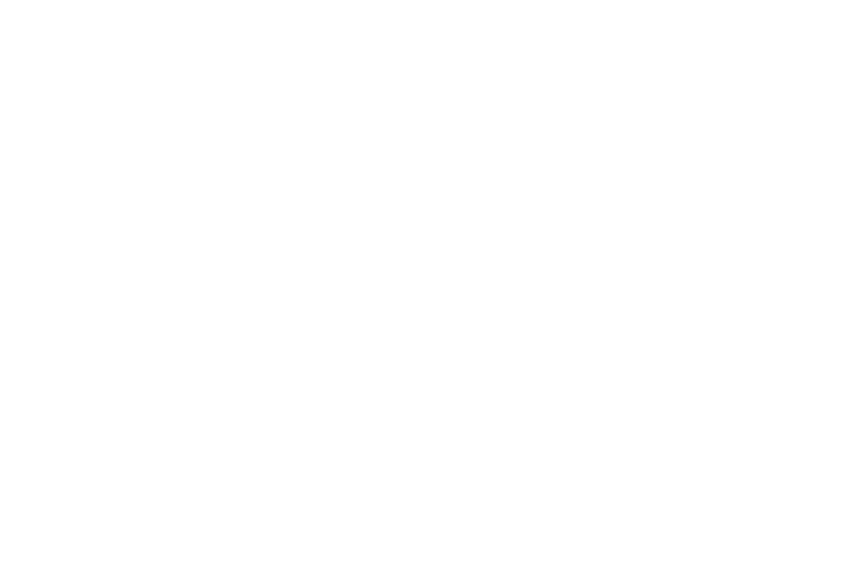

Expected Bleach 0.695676299166294


  0%|          | 0/5 [00:00<?, ?it/s]

In [244]:
%matplotlib notebook
P_STED = 150e-3
P_EX = 2.0e-6
PDT = 10.0e-6

numpy.random.seed(42)
random.seed(42)

NUM_ACQ = 1
NUM_REPS = 1
all_histories = []
i = 1
datamap_generator = DatamapGenerator(
    mode="real", shape=(224, 224), path=["../../data/datamap/psd95"], random_state=42 + i,
    molecules=num_mol, sources=25
)
molecules_disposition, positions = datamap_generator(idx=i)

fig,ax = pyplot.subplots()
ax.imshow(molecules_disposition)
pyplot.show()

microscope, datamap, params = create_microscope(
    datamap = {
        "whole_datamap" : molecules_disposition,
        "datamap_pixelsize" : 20e-9
    },
    fluo=fluo, laser_ex=laser_ex, laser_sted=laser_sted, objective=objective,
    imaging = {"p_ex" : P_EX, "p_sted" : P_STED, "pdt" : PDT}
)
bleach = expected_bleach(microscope, P_EX, P_STED, PDT)
print("Expected Bleach", bleach)

for i in trange(min(5, len(datamap_generator.datamaps)), leave=False):
# for i in trange(len(datamap_generator.datamaps), leave=False):    
    molecules_disposition, positions = datamap_generator(idx=i + 20)
    
    experiment = Experiment()
    
    microscope, datamap, params = create_microscope(
        datamap = {
            "whole_datamap" : molecules_disposition,
            "datamap_pixelsize" : 20e-9
        },
        fluo=fluo, laser_ex=laser_ex, laser_sted=laser_sted, objective=objective,
        imaging = {"p_ex" : P_EX, "p_sted" : 0., "pdt" : PDT}
    )
    experiment.add("CONF1", microscope, datamap, params)    
    experiment.add("CONF2", microscope, datamap, params)    
    
    microscope, _, params = create_microscope(
        datamap = {
            "whole_datamap" : molecules_disposition,
            "datamap_pixelsize" : 20e-9
        },
        fluo=fluo, laser_ex=laser_ex, laser_sted=laser_sted, objective=objective,
        imaging = {"p_ex" : P_EX, "p_sted" : P_STED, "pdt" : PDT}
    )
    experiment.add("STED", microscope, datamap, params)

    histories = {}
    for name in ["CONF1", "STED", "CONF2"]:
        name, history = experiment.acquire(name, NUM_ACQ, bleach="CONF" not in name, verbose=False)
        histories[name] = history
    
    all_histories.append(histories)
    

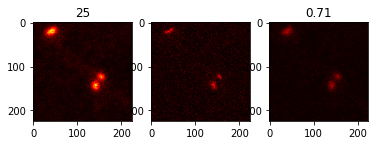

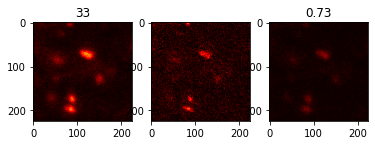

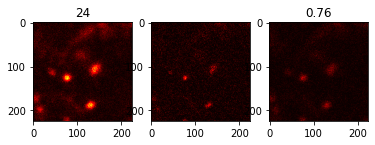

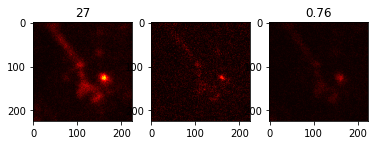

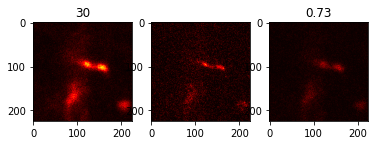

27.8


In [246]:
%matplotlib inline

resolution_objective = Resolution(20e-9)
bleach_objective = Bleach()

maxes = []
for histories in all_histories:
    conf1 = histories["CONF1"]["acquisition"][-1]
    conf2 = histories["CONF2"]["acquisition"][-1]        
    sted_image = histories["STED"]["acquisition"][-1]

    fg_c = get_foreground(conf1)
    fg_s = get_foreground(sted_image)
    fg_s *= fg_c

    resolutions = resolution_objective.evaluate([sted_image], conf1, conf2, fg_s, fg_c)
    bleach = bleach_objective.evaluate([sted_image], conf1, conf2, fg_s, fg_c)
    
    fig, axes = pyplot.subplots(1, 3)
    axes[0].imshow(conf1, cmap="hot")
    axes[0].set_title(conf1.max())
    axes[1].imshow(sted_image, cmap="hot")     
    axes[2].imshow(conf2, cmap="hot", vmax=conf1.max())    
    axes[2].set_title(f"{bleach:0.2f}")
    pyplot.show()
    
    maxes.append(conf1.max())
print(numpy.mean(maxes))